# [IAPR][iapr]: Lab 1 ‒  Image segmentation


**Group ID:** xx

**Author 1 (sciper):** Student Name 1 (xxxxx)  
**Author 2 (sciper):** Student Name 2 (xxxxx)   
**Author 3 (sciper):** Student Name 3 (xxxxx)   

**Release date:** 12.03.2021  
**Due date:** 26.03.2021 


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as preparation for the final project, which is a practical project which ties together the topics of the course. 

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook !** rerun the notebook from scratch `Kernel` > `Restart & Run All`


[iapr]: https://github.com/LTS5/iapr

---
## 0. Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [27]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')

if not os.path.exists(tar_path):
    raise Exception('Path to is not valid {}'.format(tar_path))
    
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

---
## Part 1: Brain segmentation

Your goal: compute the size of the brain (without the skull) in pixels in a 2D image of a human head taken by Magnetic Resonance Imaging (MRI) using:
* Region growing (5 pts)
* Contour detection (5 pts)
* Additional method of your choice (5 pts)

Each section should display the resulting segmenttion as well as the size in pixel of the detected region. Comment each method limitations and/or advantages.

### 1.1 Brain image visualization

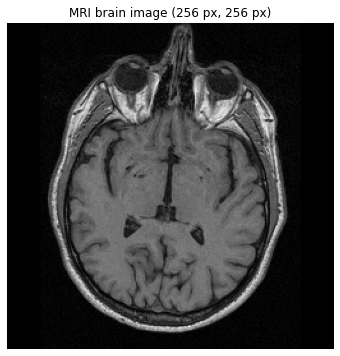

In [28]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape

# Display MRI image
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

### 1.2 Region growing (5pts)

In [29]:
# Add your implementation and discussion

### 1.3 Contour detection (5pts)

In [30]:
# Add your implementation and discussion

### 1.4 Additional method (5pts)

In [31]:
# Add your implementation and discussion

---
## Part 2: Shape/color segmentation

You will find hereafter three pictures taken under three different illuminations, containing some shapes with different colors. We ask you to create a routine to:

1. Count the number of shapes of each color (5pts).
2. Compute the total area (in pixels) of each color (5pts).

Please note that one specific challenge is to be robust to illumination changes. Therefore some kind of intensity normalization should probably be used.

### 2.1 Visualization

In [32]:
# Load images
im_names = ['arena-shapes-01', 'arena-shapes-02', 'arena-shapes-03']
filenames = [os.path.join(data_path, name) + '.png' for name in im_names]
ic = skimage.io.imread_collection(filenames)
images = skimage.io.concatenate_images(ic)
print('Number of images: ', images.shape[0])
print('Image size: {}, {} '.format(images.shape[1], images.shape[2]))
print('Number of color channels: ', images.shape[-1])

Number of images:  3
Image size: 480, 640 
Number of color channels:  3


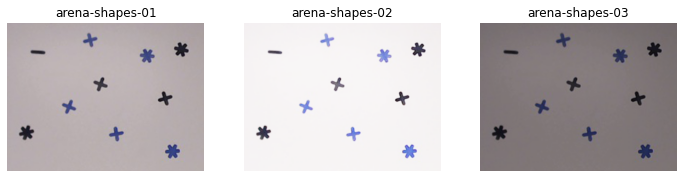

In [33]:
# Plot images
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

### 2.2 Number of shapes of each color (5 pts)

Since images could provide from different sources hence having different
illuminations, we implement scripts to normalize intensity values which
improves the robustness of our detection algorithm. For some part of the code below, we use the well-known OpenCV library.

In [34]:
import cv2 as cv
import numpy as np

Our shape labelling algorithm can be divided into 4 steps:

- Intensity normalization
- Image binarization
- Detection of shapes on the binarized image
- Labelling shapes with blue/gray criteria

####   Simple intensity rescaling
The first simple technique we've found consist to rescale the intensity values of the images to the same fixed range.
Here we rescale intensity of the image to range(0,255), which means whatever the intensity values of the input image are, the ouput
maximum intensity will be 255 and the minimum 0; values between will be scaled proportionally. Mathematically, it means:

\begin{equation}
\textrm{I}_{\textrm{out}} = \frac{I - \min(I)}{\max(I) - \min(I)} \times 255
\end{equation}

Let us now visualize how intensity rescaling affect the image. To do so, we will convert the initial RGB image into HSV (Hue Saturation Value), Value meaning Intensity Value or Luminosity. It's this last channel which will be rescaled


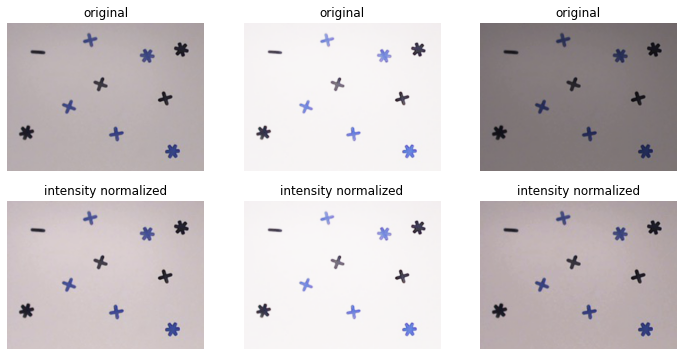

In [35]:
def normalize_intensity(img:np.ndarray)->np.ndarray:
    """
    Normalize intensity of input image
    :param img: np.ndarray input HSV image
    :return: np.ndarray RGB image intensity rescaled to 0-255 in np.uint8
    """
    # Retrieve the intensity values
    _,_,v = cv.split(img)
    v = np.uint8((v - v.min()) / (v.max() - v.min()) * 255)
    _img = img.copy()
    _img[:,:,2]= v
    # Convert to image to RGB format
    _img = cv.cvtColor(_img,cv.COLOR_HSV2RGB)
    return  _img

# Convert RGB image to HSV image
images_hsv = [cv.cvtColor(images[i],cv.COLOR_RGB2HSV) for i in range(3)]

# Let us rescale intensity of images
images_norm  = [normalize_intensity(images_hsv[i]) for i in range(3)]
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
for i in range(2):
    _collect = images if i ==0 else images_norm
    for j in range(3):
        axes[i,j].imshow(_collect[j])
        axes[i,j].set_title("original" if i==0 else "intensity normalized")
        axes[i,j].axis('off')
plt.show()

We can se that brightness of the image is slightly better after intensity normalization.

#### Histogram equalization
Histogram equalization is another preprocessing technique one can use to improve brightness of an image.
To do so, again we first retrieve the V channel (in HSV) and apply histogram normalization on it.  We prefer using the adaptive one which behave better and details can therefore be enhanced even in regions that are darker or lighter than most of the image (online skimage documentation).

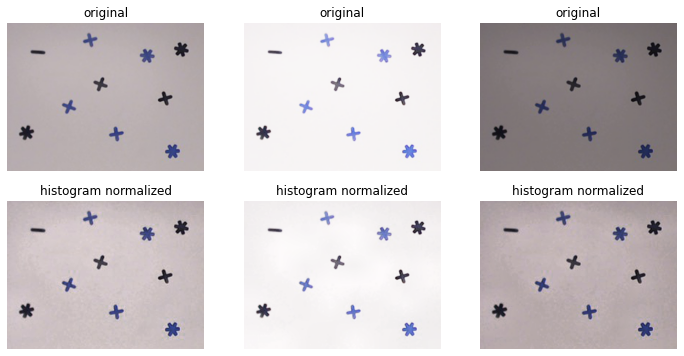

In [36]:
from skimage.exposure import equalize_adapthist, equalize_hist, histogram


def normalize_histogram(img:np.ndarray)->np.ndarray:
    """
    Normalize intensity of input image with histogram equalization
    :param img: np.ndarray input HSV image
    :return: np.ndarray RGB image intensity rescaled to 0-255 in np.uint8
    """
    # Retrieve the intensity values
    _,_,v = cv.split(img)
    v = np.uint8(equalize_adapthist(v) *255)
    _img = img.copy()
    _img[:,:,2]= v
    # Convert to image to RGB format
    _img = cv.cvtColor(_img,cv.COLOR_HSV2RGB)
    return _img

images_hist_norm = [normalize_histogram(images_hsv[i]) for i in range(3)]
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
for i in range(2):
    _collect = images if i ==0 else images_hist_norm
    for j in range(3):
        axes[i,j].imshow(_collect[j])
        axes[i,j].set_title("original" if i==0 else "histogram normalized")
        axes[i,j].axis('off')
plt.show()

Both techniques give comparable results now we can write the code of shape counting and area calculation. We want to se how intensity values are distributed after intensity normalization. So we plot the histogram of the intensity channel retrieved by HSV conversion.

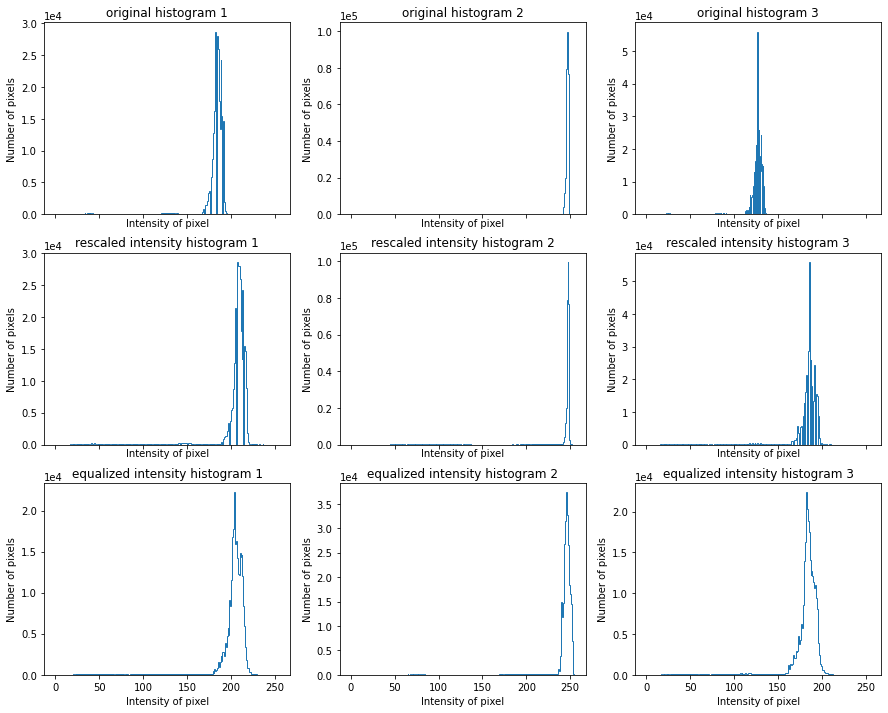

In [37]:
def get_intensity(img:np.ndarray)->np.ndarray:
    """
    Return the intensity values of the image
    :param img:
    :return:
    """
    _img = cv.cvtColor(img, cv.COLOR_RGB2HSV)
    _,_,v = cv.split(_img)
    return v
fig, axes = plt.subplots(3, 3, figsize=(15, 12), sharex=True)
axes_title = ['original histogram %d', "rescaled intensity histogram %d", "equalized intensity histogram %d"]
for i in range(3):
    _collect =[images, images_norm, images_hist_norm][i]
    for j in range(3):
        img_h_channel = get_intensity(_collect[j])
        axes[i,j].set_aspect("auto")
        axes[i,j].set_title(axes_title[i] %(j+1))
        axes[i,j].hist(img_h_channel.ravel(), bins=256, histtype='step')
        axes[i,j].ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
        axes[i,j].set_xlabel('Intensity of pixel')
        axes[i,j].set_ylabel('Number of pixels')
plt.show()

The histograms show that both intensity rescaling and histogram equalization of the luminosity channel improves brightness of the original images.

#### Image binarization
The first part of our algorithm is to binarize the input (intensity rescaled) image.
To achieve this we use threshold binarization to the input image converted to grayscale.
The values of threshold are taken arbitrary, the default values seems to be the best (by trial and error)

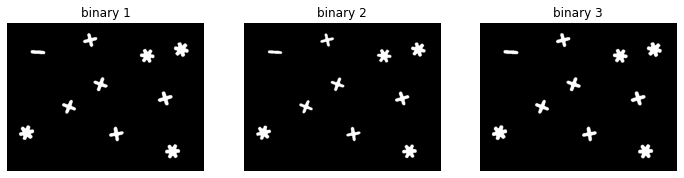

In [38]:
def binarize_image(img: np.ndarray, low=127, up=255)->np.ndarray:
    """
    Binarize the 3 channel input image
    :param img: a 3-color channel ndarray
    :param low int low limit
    :param up int high limit
    """
    _gray = cv.cvtColor(img,cv.COLOR_RGB2GRAY)
    _, _img_b = cv.threshold(_gray,low, up,cv.THRESH_BINARY_INV | cv.THRESH_OTSU)
    return _img_b

# Lets show the images
images_binary = np.array([binarize_image(im) for im in images_hist_norm])
fig, axes = plt.subplots(1, 3, figsize=(12, 6))
for ax, i in zip(axes.ravel(), range(3)):
    ax.axis('off')
    ax.set_title('binary %d' %(i+1))
    ax.imshow(images_binary[i], cmap="gray")
plt.show()

#### Counting objects
Once we have the images binarized, (shapes in white and everything else black) we can count objects.
We could multiply pixel-wise the binary image the input image for each channel got extract colored shapes.
Many appropriate techniques can be found in the literature.
The algorithm we'll use is implemented in OpenCV (it only considers binary images)
to identity all the connected components of a binary image. Connected here meaning neighbour, which is more simple in a binary image.
This method has been introduced by Kesheng Wu et al. <a href="https://sdm.lbl.gov/~kewu/ps/LBNL-59102.pdf"> Two Strategies to Speed up Connected
Component Labeling Algorithms <a/>

In [39]:
def segment_shapes(img:np.ndarray):
    """
    Return the numbers of regions detected and their coordinates
    :param img: a binary ndarray
    """
    _img_b = binarize_image(img)
    # The number of components and their labelling
    # The coordinates of each components is returned in _markers
    # _markers is therefore a 2d-array where values are not intensity value but
    # Integer labels corresponding to the shape
    # The first component is labelled 0 is the background, the second w'll be 1, the third, 2 etc.
    _count, _markers = cv.connectedComponents(_img_b)
    _regions = {}
    # Recall label 0 is the background
    for _label in range(1, _count):
        _indices = np.where(_markers==_label)
        _regions[_label] = _indices
    return _regions


Now one must have a criteria to differentiate colors in the image.
We claim there are only two colors in the input image (gray and blue).
Basically a gray color has its RGB channels with similar values (like (128,128,126)) and blue has its
blue channel predominant. Our criteria will be based on the standard deviation of the RGB color tuple.

$$ \textrm{std(c)} = \sum_{i=0}^{i=2} (c[i] - \textrm{mean(c)})^2 $$

Once we've the coordinates of a shape, we average the colors on that shape, and the resulted color is examined with our criteria.

In [40]:
def is_blue(c, std_limit=8.)->bool:
    """
    Color is blue or not
    :param std_limit:
    :param c: color tuple or len 3 -array-like
    :return: boolean True whether color is blue
    """
    # compute the standard deviation
    return np.std(c) > std_limit

Combining segmentation with the criteria above, each shape is labelled.

In [41]:
# Lists containing the blue/gray part of each image
# Each element of a list will be a dict keys being labels of identified regions
# And values being the coordinates of the identified regions
blue = [None] * 3
gray = [None] * 3
for i in range(3):
    blue[i] = dict()
    gray[i] = dict()
    _regions = segment_shapes(images_norm[i])
    for _label, _indices in _regions.items():
        # Let us check if the region detected is blue
        # To do so we average the color over the total area
        # The result color is checked to be blue or not
        if is_blue(images_norm[i][_indices].mean(axis=0)):
            blue[i][_label] = _indices
        else:
            gray[i][_label] = _indices

# Let us define to colors to color the segmented shapes
COLOR_BLUE = (0,0,255)
COLOR_GRAY = (127, 127, 127)

segmented_images = np.zeros_like(images)
blue_shapes  = np.zeros_like(images)
gray_shapes  = np.zeros_like(images)
# Now the coordinates of each identified region will be colord
# According to the color associated
for i in range(3):
    for k, indices in blue[i].items():
        segmented_images[i][indices] = COLOR_BLUE
        blue_shapes[i][indices] = COLOR_BLUE
    for k, indices in gray[i].items():
        segmented_images[i][indices] = COLOR_GRAY
        gray_shapes[i][indices] = COLOR_GRAY

Let us visualize the labelled shapes and print the counts

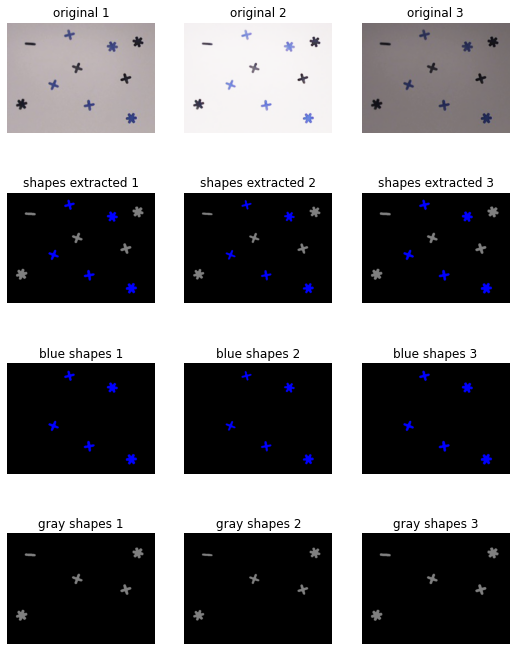

Number of colored shapes per image
Image 1
Blue shapes : 5
Gray shapes : 5
Image 2
Blue shapes : 5
Gray shapes : 5
Image 3
Blue shapes : 5
Gray shapes : 5


In [42]:
fig, axes = plt.subplots(4, 3, figsize=(9, 12))
axes_title = ['original %d', 'shapes extracted %d', 'blue shapes %d', "gray shapes %d"]
for i in range(4):
    _collect = [images, segmented_images, blue_shapes, gray_shapes][i]
    for j in range(3):
        axes[i,j].imshow(_collect[j])
        axes[i,j].set_title((axes_title[i] %(j+1)))
        axes[i,j].axis('off')
plt.show()
# blue[i] if a dict where keys are int, the labels of segmented regions
# counting the numbers of keys give us the number of shapes
# same for gray[i]
print("Number of colored shapes per image")
for i in range(3):
    print("Image %d" %(i+1))
    print("Blue shapes : %d" %len(blue[i].keys()))
    print("Gray shapes : %d" %len(gray[i].keys()))

#### Discussion on object labelling
The algorithm implemented above, allowed us to fulfill the goal of labelling and couting shapes with an input image.
Since images could provide from diverse sources, we had to implement a technique for normalizing intensity.
We did it by applying an HSV conversion coupled with  a rescaling formula.
The result is that shapes are well labelled regardless the brightness of the input image (for the given examples).
The differentiation criteria implemented here is dependent on the context (blue ang grey). With 3 or more colors, we would have had to implement another criteria and maybe optimize some hyper parameters.

### 2.3 Total area (in pixels) of each color (5 pts)
The blue and gray array contains information about the colors and the indices of the pixels which belong to the shape .

Since we've stored above the both coordinates and label in the arrays **blue** and **gray**, it becomes easier to compute the area for each shape.
The only thing we have to do is for count the number of pixels for each shape of a given color and sum then up for a given image.

In [45]:
# Let us count and print the area for each color
print("Total area of colored shapes per image")
for i in range(3):
    print("Image %d" %(i+1))
    print("Blue shapes area  : %d (pixels)" %sum([len(blue[i][j][0]) for j in blue[i].keys()]))
    print("Gray shapes area : %d (pixels)" %sum([len(gray[i][j][0]) for j in gray[i].keys()]))

Total area of colored shapes per image
Image 1
Blue shapes area  : 5029 (pixels)
Gray shapes area : 5068 (pixels)
Image 2
Blue shapes area  : 4251 (pixels)
Gray shapes area : 4513 (pixels)
Image 3
Blue shapes area  : 5149 (pixels)
Gray shapes area : 5153 (pixels)


#### Discussion on area computing
The main part of the job has been done in the section above. If the images are well laballed, then the area (number of pixels per shape) will be correctly calculated.